In [1]:
import sys
sys.path.insert(1, "../")

import importlib
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import numpy as np
from sklearn.linear_model import LogisticRegression 
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

In [2]:
def reload_modules():
    import ghost_unfairness
    importlib.reload(ghost_unfairness.fair_dataset)
    importlib.reload(ghost_unfairness.utils)
    
reload_modules()

from ghost_unfairness.fair_dataset import FairDataset, default_mappings

from ghost_unfairness.utils import *

In [3]:
protected = ["sex"]
privileged_classes = [['Male']]
metadata = default_mappings.copy()
metadata['protected_attribute_maps'] = [{1.0: 'Male', 0.0: 'Female'}]

alpha = 0.5
beta = 1

kwargs = {'protected_attribute_names': protected,
          'privileged_classes': [['Male']],
          'metadata':metadata,
          'favorable_classes': [1],
          'beta': beta,
          'alpha': alpha
         }

random_state = 47
model_type = GaussianNB

In [4]:
from copy import deepcopy
dist = {
    'mu_ps': {'p': 3, 'u': 0},
    'sigma_ps': {'p': 4, 'u': 10},
    'mu_ns': {'p': 3, 'u': 0},
    'sigma_ns': {'p': 4, 'u': 10},
}

results = {'p' : [], 'u': [], 'm': []}
deltas = []
start = 1
end = 20
for i in range(start, end):
    temp_dist = deepcopy(dist)
    mu_ps = temp_dist['mu_ps']
    for k in mu_ps:
        mu_ps[k] = mu_ps[k] + i
    kwargs['dist'] = temp_dist
    print(kwargs['dist'])    
    
    kwargs['verbose'] = False
    train_fd, test_fd = get_datasets(10000, 2, 1, kwargs, test_random_state=23)
    pmod, pmod_results = get_groupwise_performance(train_fd, train_fd, model_type,
                                                   privileged=True, pos_rate=True)
    umod, umod_results = get_groupwise_performance(train_fd, train_fd, model_type,
                                                   privileged=False, pos_rate=True)
    mod, mod_results = get_groupwise_performance(train_fd, train_fd, model_type,
                                                 privileged=None, pos_rate=True)
    
    # is_u_optimal = umod_results[4] >= pmod_results[4] and umod_results[4] >= mod_results[4] 
    is_u_optimal = umod_results[4] > pmod_results[4]
    # is_p_optimal = pmod_results[3] >= umod_results[3] and pmod_results[3] >= mod_results[3]
    is_p_optimal = pmod_results[3] > umod_results[3]
    is_m_optimal = mod_results[2] > umod_results[2] and mod_results[2] > pmod_results[2]
    
    opt_diff = is_u_optimal and is_p_optimal and is_m_optimal
    
    violates = mod_results[1] > umod_results[1] and mod_results[1] > pmod_results[1]
    
    kwargs['verbose'] = True
    if kwargs['verbose']:
        print(opt_diff)
    
        print('Violates', opt_diff and violates)
    
        print('pmod_results', *pmod_results, sep='\t')
        print('umod_results', *umod_results, sep='\t')
        print('mod_results', *mod_results, sep='\t')
    assert not (opt_diff and violates)
    
    # if opt_diff and not violates:
    results['p'].append(pmod_results)
    results['u'].append(umod_results)
    results['m'].append(mod_results)

    # print(kwargs)

{'mu_ps': {'p': 4, 'u': 1}, 'sigma_ps': {'p': 4, 'u': 10}, 'mu_ns': {'p': 3, 'u': 0}, 'sigma_ns': {'p': 4, 'u': 10}}
True
Violates False
pmod_results	-0.16720000000000002	0.7155011060064659	0.5853	0.6045	0.5661	0.6922	0.4832	0.4866	0.3544
umod_results	-0.01650000000000007	0.9740075614366729	0.59755	0.594	0.6011	0.7288	0.5408	0.7194	0.5172
mod_results	-0.03370000000000006	0.9468202619536057	0.59765	0.5955	0.5998	0.7292	0.5382	0.6998	0.5002
{'mu_ps': {'p': 5, 'u': 2}, 'sigma_ps': {'p': 4, 'u': 10}, 'mu_ns': {'p': 3, 'u': 0}, 'sigma_ns': {'p': 4, 'u': 10}}
True
Violates False
pmod_results	-0.14689999999999998	0.7308044713212388	0.60155	0.6359	0.5672	0.6816	0.4098	0.466	0.3316
umod_results	-0.04820000000000002	0.9257204499922946	0.6047	0.6043	0.6051	0.7532	0.5446	0.7058	0.4956
mod_results	-0.11209999999999998	0.8255252918287938	0.60545	0.6101	0.6008	0.7526	0.5324	0.6312	0.4296
{'mu_ps': {'p': 6, 'u': 3}, 'sigma_ps': {'p': 4, 'u': 10}, 'mu_ns': {'p': 3, 'u': 0}, 'sigma_ns': {'p': 4, 'u': 10

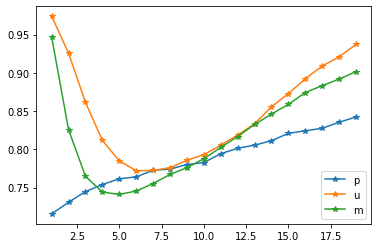

In [5]:
plt.plot(range(start, end), [i[1] for i in results['p']], '*-', label='p')
plt.plot(range(start, end), [i[1] for i in results['u']], '*-', label='u')
plt.plot(range(start, end), [i[1] for i in results['m']], '*-', label='m')
plt.legend()

0.0012999999999999678 0.009000000000000008
-0.03699999999999992 -0.05499999999999999 0.019600000000000062 0.017000000000000015
0.0042999999999999705 0.025800000000000045
-0.07100000000000006 -0.12259999999999999 0.0746 0.066
0.0019000000000000128 0.034399999999999986
-0.08020000000000005 -0.14900000000000002 0.08379999999999999 0.08000000000000002
0.006700000000000039 0.04360000000000008
-0.07399999999999995 -0.1612 0.07999999999999996 0.06659999999999999
0.006700000000000039 0.04589999999999994
-0.06619999999999993 -0.15800000000000003 0.07440000000000002 0.061
0.006000000000000005 0.04500000000000004
-0.056600000000000095 -0.14659999999999998 0.07040000000000002 0.05840000000000001
0.0036999999999999256 0.04289999999999994
-0.05159999999999998 -0.1374 0.06640000000000001 0.059
0.0029000000000000137 0.04259999999999997
-0.03979999999999995 -0.125 0.06340000000000001 0.057599999999999985
0.00029999999999996696 0.0354000000000001
-0.03939999999999999 -0.11019999999999999 0.0585999999999

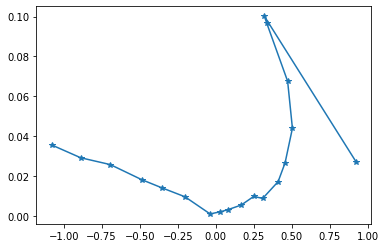

In [6]:
c_by_ds = []
di_diffs = []
for i in range(0, end - start):
    pmod_res = results['p'][i]
    umod_res = results['u'][i]
    mod_res = results['m'][i]
    di_u = umod_res[1]
    di = mod_res[1]
    acc_diff_u =  umod_res[4] - mod_res[4]
    acc_diff_p = pmod_res[3] - mod_res[3]
    print(acc_diff_u, acc_diff_p)
    del_p_plus = pmod_res[5] - mod_res[5] 
    del_p_minus = pmod_res[6] - mod_res[6]

    del_u_plus = umod_res[7] - mod_res[7]
    del_u_minus = umod_res[8] - mod_res[8]
    print(del_p_plus, del_p_minus, del_u_plus, del_u_minus)
    c = acc_diff_u + 2 * (1-alpha) * del_u_minus
    d = acc_diff_p + 2 * (1-alpha) * del_p_minus
    if d == 0:
        break
    c_by_ds.append(c/d)
    di_diffs.append(di_u - di)
    if c > d:
        assert di < di_u
        
print(*list(zip(c_by_ds, di_diffs)),sep='\n')

plt.plot(-np.log(np.abs(c_by_ds)), di_diffs, '*-')

In [7]:
acc_diff_u = [(i[0][4] - i[1][4]) for i in zip(results['u'], results['m'])]
acc_diff_u
acc_diff_p = [(i[0][3] - i[1][3]) for i in zip(results['p'], results['m'])]
acc_diff_p
di_diff = [i[0][1] - i[1][1] for i in zip(results['u'], results['m'])]
di_diff

[0.027187299483067195,
 0.10019515816350089,
 0.09662792229862516,
 0.0675582127862373,
 0.043901777237057904,
 0.026509946677604646,
 0.017101102494201714,
 0.00868557416571658,
 0.00963829774384417,
 0.005344029124224048,
 0.0029487179487179827,
 0.0019172717014152019,
 0.0008823184454793687,
 0.009505764995983546,
 0.014049031205406015,
 0.018074587211402537,
 0.025666810391245076,
 0.029097947576465444,
 0.03555950852741585]

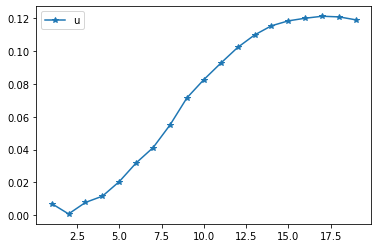

In [8]:
#plt.plot(range(-10, n), [i[3] for i in results['p']], '*-', label='p')
plt.plot(range(start, end), [abs(i[3] - i[4]) for i in results['u']], '*-', label='u')
#plt.plot(range(-10, n), [i[2] for i in results['m']], '*-', label='m')
plt.legend()

In [18]:
dist = {
    'mu_ps': {'p': 13, 'u': 10},
    'sigma_ps': {'p': 2, 'u': 5},
    'mu_ns': {'p': 3, 'u': 0},
    'sigma_ns': {'p': 2, 'u': 5},
}

model_results = {'p': [], 'u': [], 'm': []}
kwargs['dist'] = dist
model_types = [GaussianNB, LogisticRegression, DecisionTreeClassifier]
for model_type in model_types:
    
    kwargs['verbose'] = False
    train_fd, test_fd = get_datasets(10000, 10, 3, kwargs, test_random_state=47)
    pmod, pmod_results = get_groupwise_performance(train_fd, train_fd, model_type,
                                                   privileged=True, pos_rate=True)
    umod, umod_results = get_groupwise_performance(train_fd, train_fd, model_type,
                                                   privileged=False, pos_rate=True)
    mod, mod_results = get_groupwise_performance(train_fd, train_fd, model_type,
                                                 privileged=None, pos_rate=True)
    
    kwargs['verbose'] = True
    if kwargs['verbose']:
        print(opt_diff)
    
        print('Violates', opt_diff and violates)
    
        print('pmod_results', *pmod_results, sep='\t')
        print('umod_results', *umod_results, sep='\t')
        print('mod_results', *mod_results, sep='\t')
    model_results['p'].append(pmod_results)
    model_results['u'].append(umod_results)
    model_results['m'].append(mod_results)


True
Violates False
pmod_results	-0.11830000000000002	0.7634	0.93905	1.0	0.8781	1.0	0.0	0.7598	0.0036
umod_results	-0.018900000000000028	0.9637166442695334	0.97215	0.9791	0.9652	1.0	0.0418	0.9672	0.0368
mod_results	-0.04320000000000007	0.9137035557331201	0.9732	0.9994	0.947	1.0	0.0012	0.9044	0.0104
True
Violates False
pmod_results	-0.11129999999999995	0.7775334799120528	0.94135	0.9997	0.883	1.0	0.0006	0.772	0.006
umod_results	-0.01770000000000005	0.9659090909090908	0.96805	0.9808	0.9553	1.0	0.0384	0.9568	0.0462
mod_results	-0.02510000000000001	0.9501786423183803	0.97455	0.9962	0.9529	1.0	0.0076	0.9316	0.0258
True
Violates False
pmod_results	-0.11009999999999998	0.7798	0.93075	1.0	0.8615	1.0	0.0	0.7514	0.0284
umod_results	-0.04690000000000005	0.9159949847752104	0.94815	0.9417	0.9546	1.0	0.1166	0.966	0.0568
mod_results	-0.027700000000000002	0.9447326416600159	0.97135	0.9988	0.9439	1.0	0.0024	0.9174	0.0296


In [19]:
dist

{'mu_ps': {'p': 13, 'u': 10},
 'sigma_ps': {'p': 2, 'u': 5},
 'mu_ns': {'p': 3, 'u': 0},
 'sigma_ns': {'p': 2, 'u': 5}}

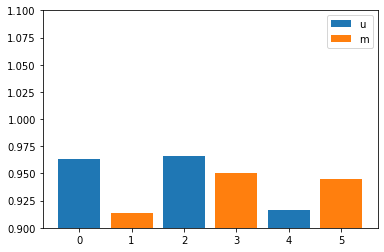

In [21]:
plt.bar(range(0, len(model_types)*2, 2), [i[1] for i in model_results['u']], label='u')
plt.bar(range(1, len(model_types)*2, 2), [i[1] for i in model_results['m']], label= 'm')
plt.ylim(0.9, 1.1)
plt.legend()

In [31]:
from copy import deepcopy
dist = {
    'mu_ps': {'p': 13, 'u': 10},
    'sigma_ps': {'p': 2, 'u': 5},
    'mu_ns': {'p': 3, 'u': 0},
    'sigma_ns': {'p': 2, 'u': 5},
}

results = {'p' : [], 'u': [], 'm': []}
start = 0
end = 10
for i in range(start, end):
    temp_dist = deepcopy(dist)
    sigma_ps = temp_dist['sigma_ps']
    sigma_ns = temp_dist['sigma_ns']
    sigma_ps['u'] = sigma_ps['u'] + i
    sigma_ns['u'] = sigma_ns['u'] + i

    print(temp_dist)    
    kwargs['dist'] = temp_dist
    kwargs['verbose'] = False
    
    train_fd, test_fd = get_datasets(10000, 2, 1, kwargs, test_random_state=47)
    pmod, pmod_results = get_groupwise_performance(train_fd, train_fd, model_type,
                                                   privileged=True, pos_rate=True)
    umod, umod_results = get_groupwise_performance(train_fd, train_fd, model_type,
                                                   privileged=False, pos_rate=True)
    mod, mod_results = get_groupwise_performance(train_fd, train_fd, model_type,
                                                 privileged=None, pos_rate=True)
    
    results['p'].append(pmod_results)
    results['u'].append(umod_results)
    results['m'].append(mod_results)

    # print(kwargs)

{'mu_ps': {'p': 13, 'u': 10}, 'sigma_ps': {'p': 2, 'u': 5}, 'mu_ns': {'p': 3, 'u': 0}, 'sigma_ns': {'p': 2, 'u': 5}}
{'mu_ps': {'p': 13, 'u': 10}, 'sigma_ps': {'p': 2, 'u': 6}, 'mu_ns': {'p': 3, 'u': 0}, 'sigma_ns': {'p': 2, 'u': 6}}
{'mu_ps': {'p': 13, 'u': 10}, 'sigma_ps': {'p': 2, 'u': 7}, 'mu_ns': {'p': 3, 'u': 0}, 'sigma_ns': {'p': 2, 'u': 7}}
{'mu_ps': {'p': 13, 'u': 10}, 'sigma_ps': {'p': 2, 'u': 8}, 'mu_ns': {'p': 3, 'u': 0}, 'sigma_ns': {'p': 2, 'u': 8}}
{'mu_ps': {'p': 13, 'u': 10}, 'sigma_ps': {'p': 2, 'u': 9}, 'mu_ns': {'p': 3, 'u': 0}, 'sigma_ns': {'p': 2, 'u': 9}}
{'mu_ps': {'p': 13, 'u': 10}, 'sigma_ps': {'p': 2, 'u': 10}, 'mu_ns': {'p': 3, 'u': 0}, 'sigma_ns': {'p': 2, 'u': 10}}
{'mu_ps': {'p': 13, 'u': 10}, 'sigma_ps': {'p': 2, 'u': 11}, 'mu_ns': {'p': 3, 'u': 0}, 'sigma_ns': {'p': 2, 'u': 11}}
{'mu_ps': {'p': 13, 'u': 10}, 'sigma_ps': {'p': 2, 'u': 12}, 'mu_ns': {'p': 3, 'u': 0}, 'sigma_ns': {'p': 2, 'u': 12}}
{'mu_ps': {'p': 13, 'u': 10}, 'sigma_ps': {'p': 2, 'u': 13

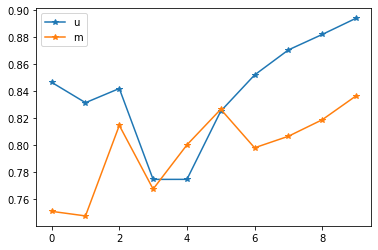

In [32]:
plt.plot(range(start, end), [i[1] for i in results['u']], '*-', label='u')
plt.plot(range(start, end), [i[1] for i in results['m']], '*-', label='m')
plt.legend()

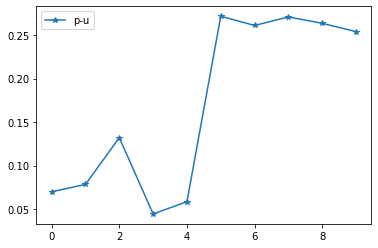

In [33]:
#plt.plot(range(-10, n), [i[3] for i in results['p']], '*-', label='p')
plt.plot(range(start, end), [abs(i[3] - i[4]) for i in results['u']], '*-', label='p-u')
#plt.plot(range(-10, n), [i[2] for i in results['m']], '*-', label='m')
plt.legend()